# Predicting Sub-grade

The next step is to predict the sub-grade assigned to a loan. Because we are
going to use the same dataset as for the grade, we will just read the pickle
file we previously generated.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pycaret.regression import *
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from script import make_mi_scores, plot_mi_scores, map_sub_grade,reverse_map_sub_grade

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_pickle('./df.pkl')

Instead of using 35 different classes, we are going to convert them to numbers from 1 to 35 and treat this as an ordinal regression problem.

In [3]:
df['Sub_Grade_Numerical'] = map_sub_grade(df['Sub_Grade'])

For the EDA part, we are going to choose the 10 features with the highest mutual information score, just like we did for Grade.

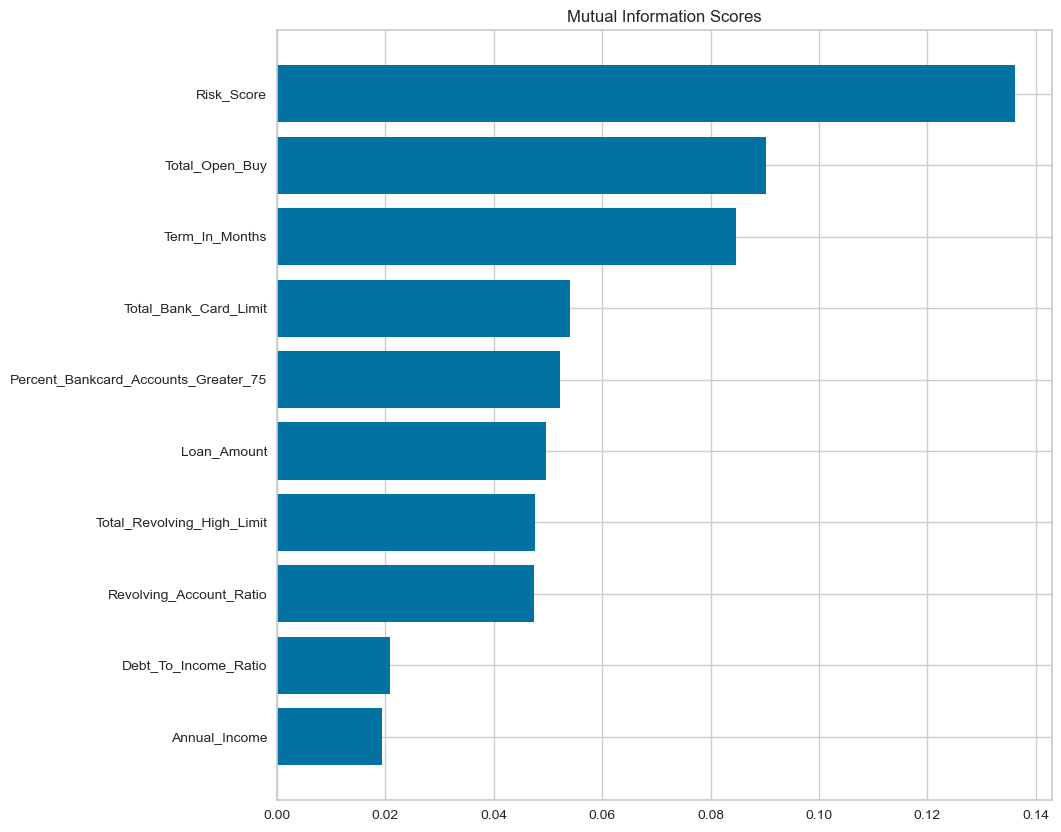

In [7]:
sample = df.sample(frac=0.05, random_state=42).dropna()
mi_scores = make_mi_scores(
    sample.drop(['Sub_Grade', 'Interest_Rate', 'id', 'Sub_Grade_Numerical'],
                axis=1)
    .select_dtypes
    (include=np.number), sample['Sub_Grade'])

plt.figure(dpi=100, figsize=(10, 10))
plot_mi_scores(mi_scores.nlargest(10))

## Exploratory Data Analysis

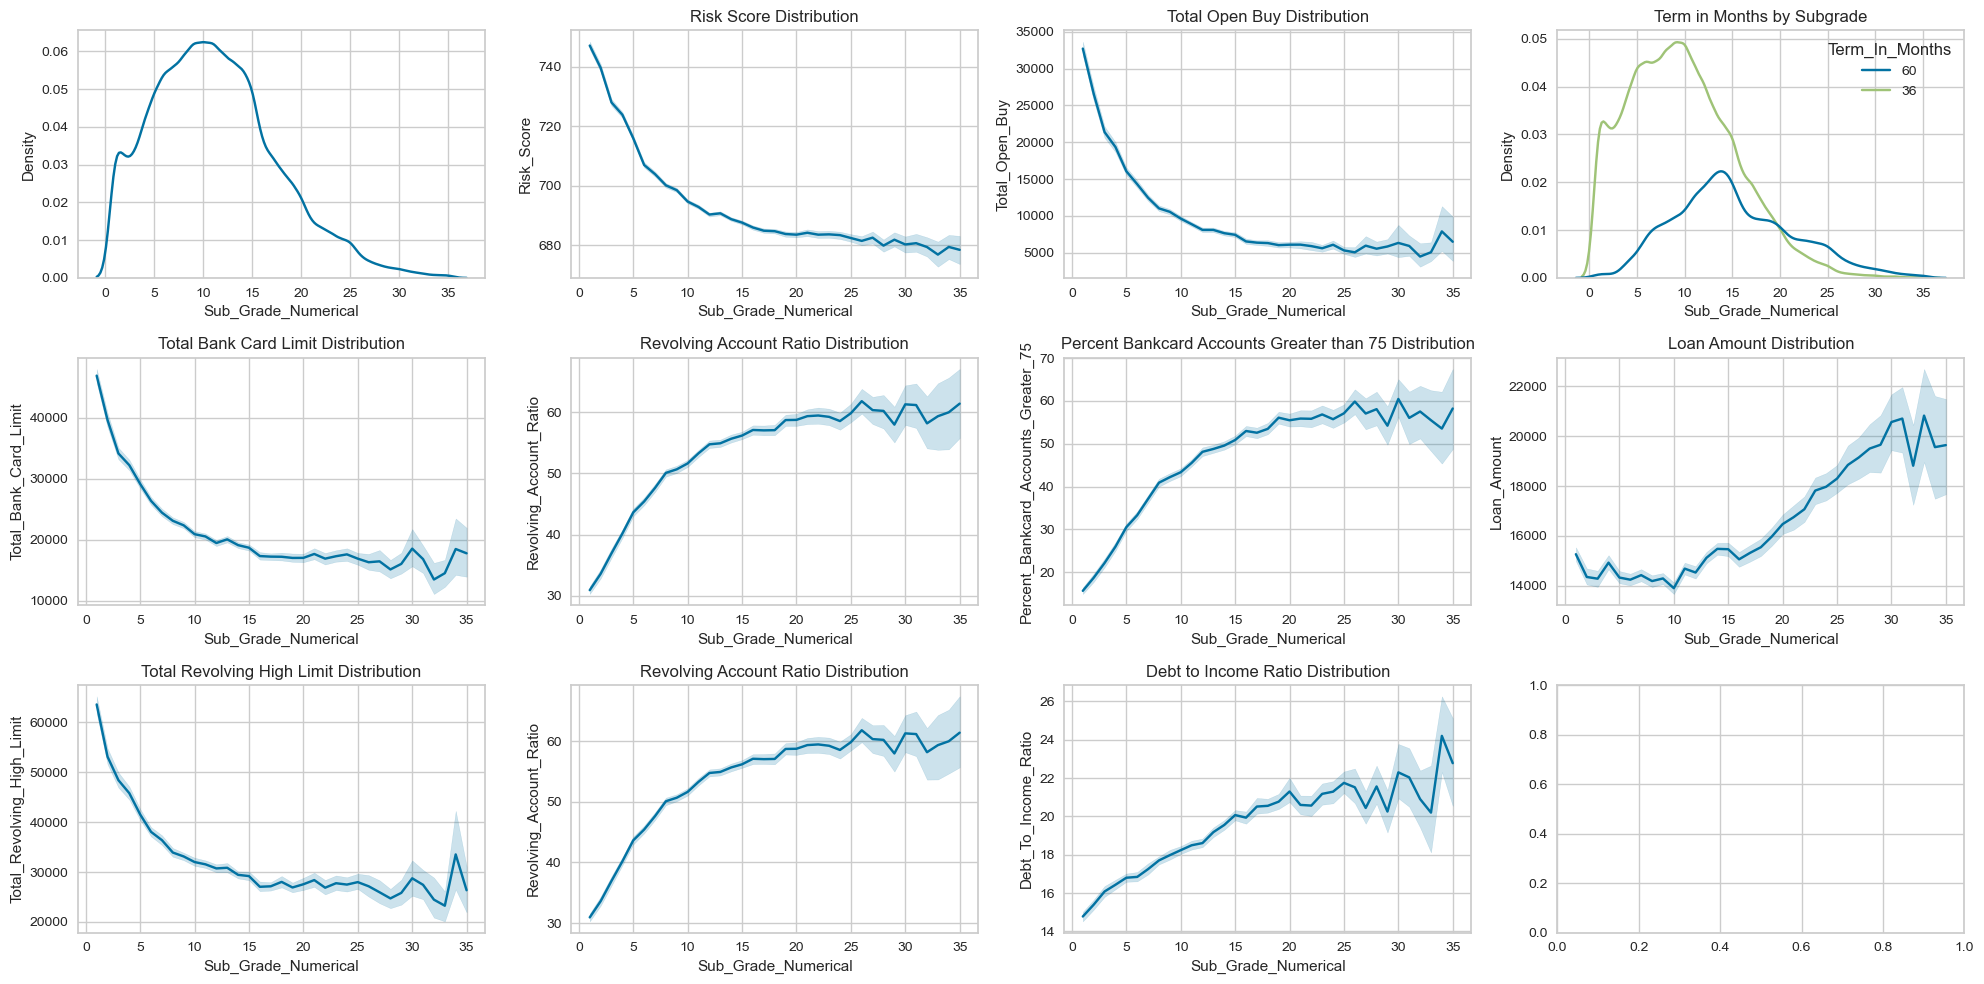

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

df_sample = df.sample(100000)

sns.kdeplot(data=df_sample, x='Sub_Grade_Numerical', ax=axes[0, 0])
axes[0, 1].set_title('Subgrade Distribution')

sns.lineplot(data=df_sample, y='Risk_Score', x='Sub_Grade_Numerical',
             ax=axes[0, 1])
axes[0, 1].set_title('Risk Score Distribution')

sns.lineplot(data=df_sample, y='Total_Open_Buy', x='Sub_Grade_Numerical',
             ax=axes[0, 2])
axes[0, 2].set_title('Total Open Buy Distribution')

sns.kdeplot(x=df_sample['Sub_Grade_Numerical'],
            hue=df_sample['Term_In_Months'].astype(str),
            ax=axes[0, 3])
axes[0, 3].set_title('Term in Months by Subgrade')

sns.lineplot(data=df_sample, y='Total_Bank_Card_Limit', x='Sub_Grade_Numerical',
             ax=axes[1, 0])
axes[1, 0].set_title('Total Bank Card Limit Distribution')

sns.lineplot(data=df_sample, y='Revolving_Account_Ratio',
             x='Sub_Grade_Numerical',
             ax=axes[1, 1])
axes[1, 1].set_title('Revolving Account Ratio Distribution')

sns.lineplot(data=df_sample, y='Percent_Bankcard_Accounts_Greater_75',
             x='Sub_Grade_Numerical',
             ax=axes[1, 2])
axes[1, 2].set_title('Percent Bankcard Accounts Greater than 75 Distribution')

sns.lineplot(data=df_sample, y='Loan_Amount', x='Sub_Grade_Numerical',
             ax=axes[1, 3])
axes[1, 3].set_title('Loan Amount Distribution')

sns.lineplot(data=df_sample, y='Total_Revolving_High_Limit',
             x='Sub_Grade_Numerical',

             ax=axes[2, 0])
axes[2, 0].set_title('Total Revolving High Limit Distribution')

sns.lineplot(data=df_sample, y='Revolving_Account_Ratio',
             x='Sub_Grade_Numerical',
             ax=axes[2, 1])
axes[2, 1].set_title('Revolving Account Ratio Distribution')

sns.lineplot(data=df_sample, y='Debt_To_Income_Ratio', x='Sub_Grade_Numerical',
             ax=axes[2, 2])
axes[2, 2].set_title('Debt to Income Ratio Distribution')

plt.tight_layout()
plt.show()

Just like with Grade, we see a trend in all subplots. The worse the sub-grade, the higher the revolving account ratio, percent of bankcard accounts greater than 75, loan amount, revolving account ratio and debt to income ratio, while the rest of features follow a decreasing pattern.

## Statistical Analysis

Since we are dealing with continuous features, we will use Pearson's correlation coefficients to find any potential correlations among our features.

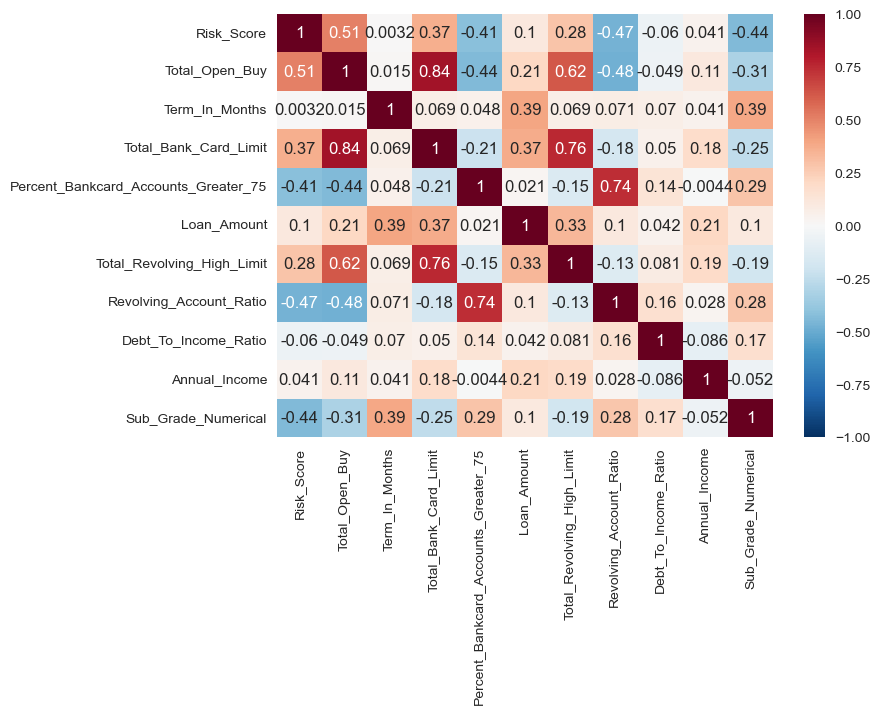

In [8]:
features_highest_mi = mi_scores.nlargest(10).index
df_filtered = df[features_highest_mi]
df_filtered['Sub_Grade_Numerical'] = df['Sub_Grade_Numerical']
sns.heatmap(
    df_filtered.corr(numeric_only=True),
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)
plt.show()

The dependent feature does not seem to be correlated to any of the
other features. We do see some strong correlations between some features, such
as the total bank card limit and the total open buy. An absolute coefficient
higher than 0.5 is considered moderate correlation, while two features with a
 coefficient higher than 0.7 are highly correlated.

## Statistical Modelling

Since this is the last step of our project, we can assume we have already predicted the loan grade. Therefore, we will keep it as a feature for our model.

In [10]:
X = df.drop(['id', 'Interest_Rate', 'Sub_Grade', 'Sub_Grade_Numerical'], axis=1)
y = df['Sub_Grade']

Even though we numerified the subgrade, we still want it to be evenly represented in our dataset splits. Therefore, we are going to use stratification.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    stratify=y,
                                                    random_state=42)

In [59]:
X_pycaret, X_rest, y_pycaret, y_rest = train_test_split(X_train, y_train,
                                                        train_size=1 / 7,
                                                        stratify=y_train,
                                                        random_state=42)

In [60]:
y_pycaret = map_sub_grade(y_pycaret)

In [12]:
y_train = map_sub_grade(y_train)

In [13]:
y_test = map_sub_grade(y_test)

To speed up the process, we will set up an experiment with a sample first,
from which we will retrieve the best model and hyperparameters.

In [ ]:
s = setup(pd.concat([X_pycaret, y_pycaret], axis=1), target='Sub_Grade',
          session_id=123, experiment_name='tune_sample')

In [37]:
best_subgrade_model = compare_models(exclude=['svm', 'dummy', 'gbr'],
                                     sort='RMSE')
save_model(best_subgrade_model, 'model_subgrade_untuned')
tuned_best_subgrade_model, tuner = tune_model(best_subgrade_model,
                                              optimize='RMSE', tuner_verbose=3,
                                              return_tuner=True)
save_model(tuned_best_subgrade_model, 'model_subgrade_tuned')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,MMAE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.1456,1.7871,1.3368,0.9551,0.1803,0.1810,0.0000,2.5610
xgboost,Extreme Gradient Boosting,1.1474,1.8138,1.3468,0.9544,0.1814,0.1803,0.0000,3.5790
rf,Random Forest Regressor,1.1573,1.8280,1.3520,0.9541,0.1832,0.1843,0.0000,109.5160
et,Extra Trees Regressor,1.1587,1.8416,1.3571,0.9537,0.1832,0.1840,0.0000,102.1220
lr,Linear Regression,1.1720,1.8576,1.3629,0.9533,0.1895,0.1949,0.0000,2.2630
ridge,Ridge Regression,1.1719,1.8575,1.3629,0.9533,0.1895,0.1949,0.0000,1.3390
br,Bayesian Ridge,1.1719,1.8576,1.3629,0.9533,0.1895,0.1949,0.0000,2.1210
ada,AdaBoost Regressor,1.3323,2.5199,1.5844,0.9367,0.1996,0.2004,0.0000,35.9320
dt,Decision Tree Regressor,1.4943,3.6378,1.9073,0.9086,0.2573,0.2286,0.0000,3.5620
en,Elastic Net,3.5791,21.2938,4.6145,0.4650,0.4508,0.5670,0.0000,10.0740


Transformation Pipeline and Model Successfully Saved


,MAE,MSE,RMSE,R2,RMSLE,MAPE,MMAE
Fold,,,,,,,
0,1.1632,1.8284,1.3522,0.9533,0.1843,0.1876,-0.0000
1,1.1646,1.8388,1.3560,0.9539,0.1860,0.1888,-0.0000
2,1.1621,1.8232,1.3503,0.9538,0.1848,0.1880,-0.0000
3,1.1575,1.8110,1.3457,0.9541,0.1864,0.1906,-0.0000
4,1.1568,1.8103,1.3455,0.9547,0.1815,0.1824,-0.0000
5,1.1526,1.7983,1.3410,0.9554,0.1836,0.1862,-0.0000
6,1.1611,1.8165,1.3478,0.9545,0.1833,0.1873,-0.0000
7,1.1643,1.8278,1.3520,0.9543,0.1805,0.1817,-0.0000
8,1.1557,1.8094,1.3451,0.9542,0.1833,0.1853,-0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Number_Trades_24_Months',
                                              'Annual_Income', 'Total_Open_Buy',
                                              'Number_Delinquent_2_Years',
                                              'Delinquent_Amount',
                                              'Debt_To_Income_Ratio',
                                              'Employment_Length_In_Years',
                                              'Loan_Amount', 'Risk_Score',
                                              'Inquiries_6_Months',
                                              'Mortgage_Accounts', 'Open_Trades',
                                              'Revolving_Acco...
                                              'Verification_Status'],
                                     transformer=OneHotEncoder(cols=['Grade',
                                         

Now, we will use said model for the whole train set.
Since hyperparameter tuning did not improve the model's performance, we will
not tune the model this time.

In [14]:
s = setup(pd.concat([X_train, y_train], axis=1), target='Sub_Grade',
          session_id=123, experiment_name='final_model')

,Description,Value
0,Session id,123
1,Target,Sub_Grade
2,Target type,Regression
3,Original data shape,"(1582467, 104)"
4,Transformed data shape,"(1582467, 130)"
5,Transformed train set shape,"(1107726, 130)"
6,Transformed test set shape,"(474741, 130)"
7,Numeric features,98
8,Categorical features,5
9,Rows with missing values,22.1%


In [41]:
s = setup(pd.concat([X_train, y_train], axis=1), target='Sub_Grade',
          session_id=123, experiment_name='final_model')
model_subgrade_tuned = create_model('lightgbm')
save_model(model_subgrade_tuned, 'model_subgrade_final')

,Description,Value
0,Session id,123
1,Target,Sub_Grade
2,Target type,Regression
3,Original data shape,"(1582467, 104)"
4,Transformed data shape,"(1582467, 130)"
5,Transformed train set shape,"(1107726, 130)"
6,Transformed test set shape,"(474741, 130)"
7,Numeric features,98
8,Categorical features,5
9,Rows with missing values,22.1%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
1,1.1421,1.7755,1.3325,0.9549,0.1794,0.1803
2,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
3,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
4,1.1431,1.7796,1.3340,0.9552,0.1793,0.1805
5,1.1392,1.7693,1.3302,0.9552,0.1792,0.1793
6,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
7,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
8,1.1464,1.7847,1.3359,0.9552,0.1815,0.1828


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Number_Trades_24_Months',
                                              'Annual_Income', 'Total_Open_Buy',
                                              'Number_Delinquent_2_Years',
                                              'Delinquent_Amount',
                                              'Debt_To_Income_Ratio',
                                              'Employment_Length_In_Years',
                                              'Loan_Amount', 'Risk_Score',
                                              'Inquiries_6_Months',
                                              'Mortgage_Accounts', 'Open_Trades',
                                              'Revolving_Acco...
                                              'Verification_Status'],
                                     transformer=OneHotEncoder(cols=['Grade',
                                         

Alternatively, run `model_subgrade_tuned = load_model
('sub_grade/model_subgrade_tuned')` to load the model directly.

Using evaluate model, we can analyse some of its metrics.

In [16]:
evaluate_model(model_subgrade_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Now let us finalise it and test it with unseen data

In [17]:
model_subgrade_finalized = finalize_model(model_subgrade_tuned)

In [18]:
pred_unseen = predict_model(model_subgrade_finalized,
                            pd.concat([X_test, y_test], axis=1))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.1434,1.7790,1.3338,0.9552,0.1797,0.1806


In [20]:
save_model(model_subgrade_finalized, 'sub_grade/model_subgrade_finalized')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\guill\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Number_Trades_24_Months',
                                              'Annual_Income', 'Total_Open_Buy',
                                              'Number_Delinquent_2_Years',
                                              'Delinquent_Amount',
                                              'Debt_To_Income_Ratio',
                                              'Employment_Length_In_Years',
                                              'Loan_Amount', 'Risk_Score',
                                              'Inquiries_6_Months',
                                              'Mortgage...
                                              'Verification_Status'],
                                     transformer=OneHotEncoder(cols=['Grade',
                                                                     'Home_Ownership',
  

Since our goal is to predict values from A1 to G5, we are going to convert the
predictions back to sub-grades.

In [22]:
pred_unseen[['Sub_Grade', 'prediction_label']]

,Sub_Grade,prediction_label
898049,11,12.668021
630570,1,2.769821
725428,16,17.593911
747549,1,2.568582
1314508,28,27.413605
...,...,...
2074638,2,4.114148
2141517,14,12.651867
242373,16,17.884037
1029341,2,3.418171


In [24]:
pred_unseen['predicted_subgrade'] = \
    reverse_map_sub_grade(pred_unseen['prediction_label'])
pred_unseen['Sub_Grade'] =  reverse_map_sub_grade(pred_unseen['Sub_Grade'])

print(classification_report(pred_unseen['Sub_Grade'],
                            pred_unseen['predicted_subgrade']))

              precision    recall  f1-score   support

          A1       0.79      0.06      0.11     26037
          A2       0.23      0.30      0.26     20869
          A3       0.21      0.50      0.29     21955
          A4       0.30      0.48      0.37     28762
          A5       0.70      0.03      0.07     32285
          B1       0.00      0.00      0.00     37602
          B2       0.25      0.11      0.15     37986
          B3       0.21      0.81      0.33     39454
          B4       0.27      0.18      0.22     41938
          B5       0.92      0.00      0.00     42087
          C1       0.00      0.00      0.00     43771
          C2       0.24      0.08      0.12     39335
          C3       0.20      0.91      0.33     38758
          C4       0.32      0.05      0.09     38135
          C5       0.00      0.00      0.00     35018
          D1       0.00      0.00      0.00     24536
          D2       0.26      0.12      0.16     21870
          D3       0.20    

When we convert it back to sub-grades, we see that the model might not be
suitable for deployment. Some classes are never predicted, and those which
are get low scores overall.

In [29]:
confusion_matrix(pred_unseen['Sub_Grade'],
                 pred_unseen['predicted_subgrade'])

array([[ 1574, 12852,  9614, ...,     0,     0,     0],
       [  269,  6184, 10517, ...,     0,     0,     0],
       [   93,  3904, 10965, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,   148,     0,     0],
       [    0,     0,     0, ...,   145,     0,     0],
       [    0,     0,     0, ...,   109,     0,     0]], dtype=int64)

Although this model has room for improvement, for the time being, we will
move on to the last phase of our project.